## Watershed Algorithm
- [Image Segmentation with Watershed Algorithm](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html)
- [IMAGE SEGMENTATION AND MATHEMATICAL MORPHOLOGY](https://people.cmm.minesparis.psl.eu/users/beucher/wtshed.html)
<br>

__[link text](https://people.cmm.minesparis.psl.eu/users/beucher/wtshed.html)__
`string`
[Custom Seeds with the WaterShed Algorithm](#Custom-Seeds-with-the-WaterShed-Algorithm)
[Section title](#section_ID)



<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

<div class="alert alert-block alert-warning">
<b>Example:</b> Use yellow boxes for examples that are not 
inside code cells, or use for mathematical formulas if needed.
</div>

<div class="alert alert-block alert-success">
<b>Up to you:</b> Use green boxes sparingly, and only for some specific 
purpose that the other boxes can't cover. For example, if you have a lot 
of related content to link to, maybe you decide to use green boxes for 
related links from each section of a notebook.
</div>

In [3]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt


In [31]:
img = cv2.imread('images/water_coins.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

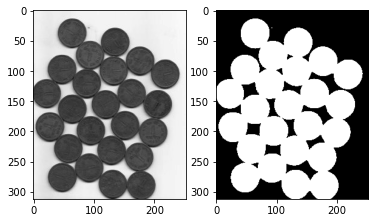

In [32]:
plt.subplot(1,2,1)
plt.imshow(gray,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(thresh,cmap='gray')

In [10]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)


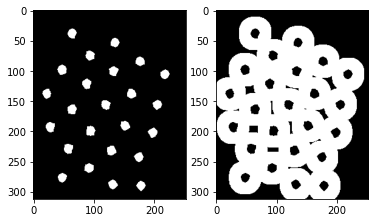

In [13]:
plt.subplot(1,2,1)
plt.imshow(sure_fg,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(unknown,cmap='gray')

In [11]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

25


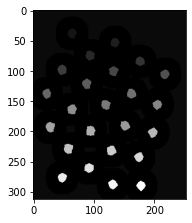

In [16]:
plt.subplot(1,2,1)
plt.imshow(markers,cmap='gray')
print(ret)

<a id="section_ID"></a>

In [21]:
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]

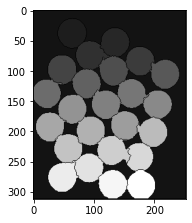

In [22]:
plt.subplot(1,2,1)
plt.imshow(markers,cmap='gray')

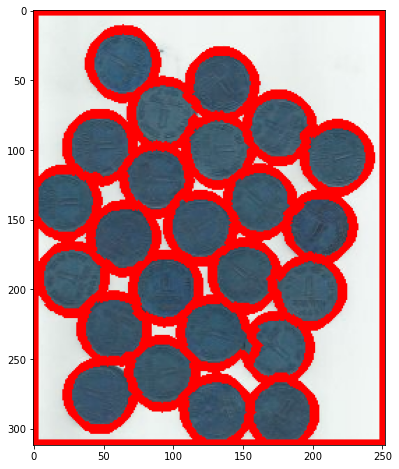

In [34]:
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(img, contours, i, (255, 0, 0), 2)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.imshow(img)

## Custom Seeds with the WaterShed Algorithm

0-9 to set color


In [4]:
road = cv2.imread('images/road_image.jpg')
road_copy = np.copy(road)
# Create an empty space for the results to be drawn
marker_image = np.zeros(road.shape[:2],dtype=np.int32)
segments = np.zeros(road.shape,dtype=np.uint8)

### Create colors for Markers

https://matplotlib.org/examples/color/colormaps_reference.html

In [5]:
from matplotlib import cm

In [6]:
# Returns (R,G,B,Alpha) we only need RGB values
def create_rgb(i):
    x = np.array(cm.tab10(i))[:3]*255
    return tuple(x)

In [7]:
colors = []
# One color for each single digit
for i in range(10):
    colors.append(create_rgb(i))
colors

[(31.0, 119.0, 180.0),
 (255.0, 127.0, 14.0),
 (44.0, 160.0, 44.0),
 (214.0, 39.0, 40.0),
 (148.0, 103.0, 189.0),
 (140.0, 86.0, 75.0),
 (227.0, 119.0, 194.0),
 (127.0, 127.0, 127.0),
 (188.0, 189.0, 34.0),
 (23.0, 190.0, 207.0)]

In [8]:
# Numbers 0-9
n_markers = 10
# Default settings
current_marker = 1
marks_updated = False

In [9]:
def mouse_callback(event, x, y, flags, param):
    global marks_updated 

    if event == cv2.EVENT_LBUTTONDOWN:
        
        # TRACKING FOR MARKERS
        cv2.circle(marker_image, (x, y), 10, (current_marker), -1)
        
        # DISPLAY ON USER IMAGE
        cv2.circle(road_copy, (x, y), 10, colors[current_marker], -1)
        marks_updated = True


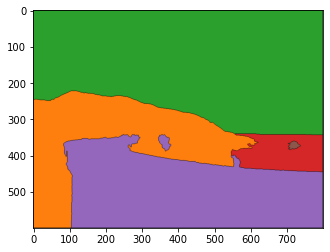

In [11]:
cv2.namedWindow('Road Image')
cv2.setMouseCallback('Road Image', mouse_callback)

while True:
    
    # SHow the 2 windows
    cv2.imshow('WaterShed Segments', segments)
    cv2.imshow('Road Image', road_copy)
        
        
    # Close everything if Esc is pressed
    k = cv2.waitKey(1)

    if k == 27:
        break
        
    # Clear all colors and start over if 'c' is pressed
    elif k == ord('c'):
        road_copy = road.copy()
        marker_image = np.zeros(road.shape[0:2], dtype=np.int32)
        segments = np.zeros(road.shape,dtype=np.uint8)
        
    # If a number 0-9 is chosen index the color
    elif k > 0 and chr(k).isdigit():
        # chr converts to printable digit
        
        current_marker  = int(chr(k))
        
        # CODE TO CHECK INCASE USER IS CARELESS
#         n = int(chr(k))
#         if 1 <= n <= n_markers:
#             current_marker = n
    
    # If we clicked somewhere, call the watershed algorithm on our chosen markers
    if marks_updated:
        
        marker_image_copy = marker_image.copy()
        cv2.watershed(road, marker_image_copy)
        
        segments = np.zeros(road.shape,dtype=np.uint8)
        
        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]
        
        marks_updated = False
        
cv2.destroyAllWindows()
plt.imshow(segments)